# Missing data mechanisms

13 May 2021

---

## Description

This notebook describes the different missing data mechanisms and illustrates them with some numerical examples.


## Summary
- **MCAR Missing completely at random**: no systemic differences (differences in the distributions of missing and non-missing values).
    - Example: measurement device breaks down at random times
    - Missingness of outcome independent of outcome and predictors
- **MAR Missing at random**: systematic differences can be explained by differences in <i>observed</i> data
    - Example: missing blood pressure measurements lower since these relate to the age of patients who are less likely to appear (and the age is recorded)
    - Missingness of outcome dependent on predictors but not outcome itself
- **MNAR Missing Not At Random**: Systematic differences cannot be explained by observed data.
    - missingness of outcome dependent on outcome itself.


## Questions
- Removing observations where there is a missing value leads to biased estimates if data MAR. Why?
    - If MCAR then probability of being missing independent of any other data, by definition. Subsets of Y1 and Y2 are then samples from the same distribution.
- For a given problem, how do we determine which is the correct missing data mechanism?
    - Cannot test between MAR and MNAR because information required is not available
    - There are tests that distinguish between MCAR and MAR but these are not widely used.
    
    
## References

- https://stefvanbuuren.name/fimd/sec-idconcepts.html

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import binom
from scipy.stats import multivariate_normal

sns.set()
%matplotlib inline

## Useful functions

In [22]:
# used in the missingness probabilities
def sigmoid(z):
    return np.exp(z) / (1 + np.exp(z))

# Numerical examples


$Y: n\times p$ matrix where $y_{ij}$ are the complete set of data. $n$ is the number of observations. $p$ is the number of variables.

$R: n\times p$ matrix where $r_{ij}=1$ if $y_{ij}$ is observed and $r_{ij}=0$ if $y_{ij}$ is missing.

Write $Y = (Y_{obs}, Y_{mis})$

The probability of being missing is determined by the equation

$P(R=0 | Y_{obs}, Y_{mis}, \psi) = \psi_0 + \frac{e^{Y_1}}{1 + e^{Y_1}}\psi_1 + \frac{e^{Y_2}}{1 + e^{Y_2}}\psi_2$,

where $\psi$ contains all the parameters of the model

Generate data for the $Y_1$ and $Y_2$ matrices.

In [15]:
# create meshgrid, i.e., two matrices with the ij element of the first being the x-coordinate of the mesh
# and the ij element of the second being the y-coordinate
x, y = np.mgrid[-1:1:.01, -1:1:.01]

# create meshgrid matrix so elements [i, j, 0] correspond to x coords and [i, j, 1] correspond to y
pos = np.dstack((x, y))

In [6]:
# multivariate mean 0 and unit covariance matrix
rv = multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]])

In [16]:
num_samples = 2**10

# create the Y1, Y2 matrices that form the complete data
# Y2 will have some values dropped
Y1, Y2 = zip(*rv.rvs(num_samples))

In [17]:
# check the mean and covariance
np.mean(Y1), np.mean(Y2)

(-0.021516735099557045, -0.009940317448133725)

In [18]:
np.cov(Y1, Y2)

array([[0.96524025, 0.49541881],
       [0.49541881, 1.02109183]])

In [19]:
mu_Y2 = np.mean(Y2)
mu_Y1 = np.mean(Y1)

In [20]:
Y1 = np.array(Y1).reshape(-1, 1)
Y2 = np.array(Y2).reshape(-1, 1)

In [21]:
(1 / num_samples * (Y1 - mu_Y1) * (Y2 - mu_Y2)).sum()

0.4949350063606043

# Missingness mechanisms

Write $Y = (Y_1, Y_2)$ where $Y_2$ has missing values. Here $Y_1$ and $Y_2$ are single column matrices and $R=R_2$ describes which values in $Y_2$ are missing.


## MCAR: Missing Completely At Random

$P(R_2=0) = \psi_0$

- Probability that Y2 = 0 is 0.5
- Real-world example: a machine to measure blood pressure randomly malfunctions so blood pressure measurements are MCAR.

In [69]:
# probability of being missing is random
rv = binom(1, 0.5)
R = rv.rvs(num_samples).reshape(-1, 1)

In [70]:
# to full dataset
# all values in Y1 and Y2
df_complete = pd.DataFrame(data={'Y1': list(Y1.reshape(-1,)), 'Y2': list(Y2.reshape(-1,))})

# the observed dataset
# values in Y2 set to nan based on value of R
df_obs = df_complete.copy()
df_obs.loc[np.where(R == 0)[0], 'Y2'] = np.nan

In [71]:
# the values that make up the 'missing matrix'
df_mis = df_complete.copy()
df_mis['col1'] = 0
df_mis['col2'] = 0
df_mis.loc[np.where(R == 0)[0], 'col2'] = Y2.reshape(-1,)[R.reshape(-1,) == 0]

## What do the observed and missing data distributions look like?

The missing and observed values should be similar

In [72]:
# what do the observed and the missing distributions look like for Y2?
Y2_obs = df_obs[df_obs['Y2'].isnull() == False]['Y2'].values
Y2_mis = df_mis[df_obs['Y2'].isnull()]['Y2'].values

In [73]:
# how many instances of each
Y2_obs.shape, Y2_mis.shape

((503,), (521,))

In [74]:
# create label variable according to whether the value is observed or not
data_labels = ['observed' for _ in range(0, Y2_obs.shape[0])] + ['missing' for _ in range(0, Y2_mis.shape[0])]
data_values = np.concatenate([Y2_obs, Y2_mis])

In [75]:
df_tidy1 = pd.DataFrame(data={'value': data_values, 'label': data_labels})

In [76]:
df_tidy1['label'] = df_tidy['label'].astype('category')

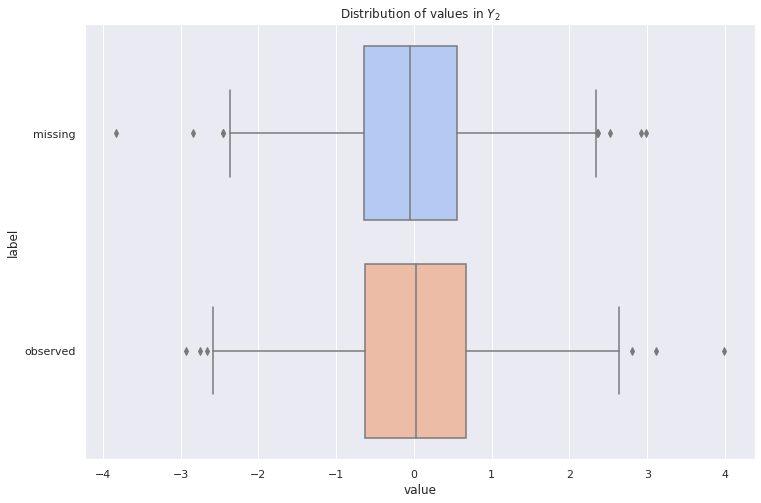

In [77]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='value', y='label', data=df_tidy1, palette='coolwarm')
plt.title('Distribution of values in $Y_2$')
plt.show()

## Imputation

How does the complete case imputation approach compare with the actual data?

In [78]:
# drop all rows where this is a missing value
df_dropped = df_obs.dropna(how='any')

# create labels depending on whether value is from complete or dropped dataset
df_dropped['label'] = 'dropped'
df_complete['label'] = 'complete'

df_full = pd.concat([df_dropped, df_complete])

/tmp/ipykernel_134878/2580584350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped['label'] = 'dropped'


In [79]:
df_full = df_full.reset_index().iloc[:, 1:]

<Figure size 432x288 with 0 Axes>

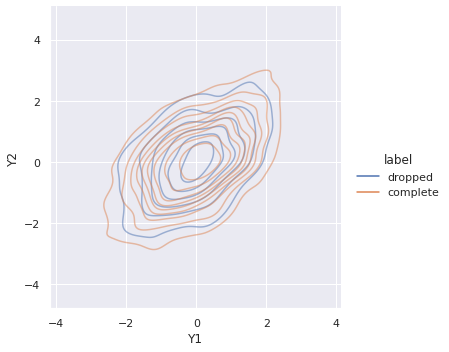

In [80]:
plt.figure(figsize=(6, 4))
ax = sns.displot(data=df_full, x='Y1', y='Y2', hue='label', alpha=0.5, kind='kde')
plt.show()

In [81]:
# distributions of Y1 when Y2 is missing vs not
Y1_obs = df_obs[df_obs['Y2'].isnull() == False]['Y1'].values
Y1_mis = df_obs[df_obs['Y2'].isnull() == True]['Y1'].values

In [82]:
df_Y1_obs = pd.DataFrame(data={'Y1': Y1_obs})
df_Y1_obs['missing'] = 0

df_Y1_mis = pd.DataFrame(data={'Y1': Y1_mis})
df_Y1_mis['missing'] = 1

df_Y1 = pd.concat([df_Y1_mis, df_Y1_obs]).reset_index().iloc[:, 1:]

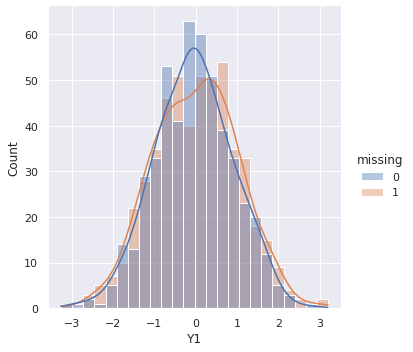

In [83]:
ax = sns.displot(data=df_Y1, x='Y1', hue='missing', alpha=0.4, kde=True)

## MAR: Missing At Random

$P(R_2=0) = \frac{e^{Y_1}}{1 + e^{Y_1}}\psi_1$,

where $\psi_1=1$.

The probability of being missing in Y2 depends on Y1. When Y1 is larger, higher probability of Y2 being missing.



In [84]:
vals = np.random.rand(Y1.shape[0]).reshape(-1, 1)
R_mar = 1 - (sigmoid(Y1) >= vals).astype(int)

In [85]:
# the observed dataset
df_obs = df_complete.copy()
df_obs.loc[np.where(R_mar == 0)[0], 'Y2'] = np.nan

# the missing dataset
df_mis = df_complete.copy()
df_mis['col1'] = 0
df_mis['col2'] = 0
df_mis.loc[np.where(R_mar == 0)[0], 'col2'] = Y2.reshape(-1,)[R_mar.reshape(-1,) == 0]

In [86]:
# what do the observed and the missing distributions look like for Y2?
Y2_obs = df_obs[df_obs['Y2'].isnull() == False]['Y2'].values
Y2_mis = df_mis[df_obs['Y2'].isnull()]['Y2'].values

In [87]:
data_labels = ['observed' for _ in range(0, Y2_obs.shape[0])] + ['missing' for _ in range(0, Y2_mis.shape[0])]
data_values = np.concatenate([Y2_obs, Y2_mis])

df_tidy2 = pd.DataFrame(data={'value': data_values, 'label': data_labels})
df_tidy2['label'] = df_tidy2['label'].astype('category')

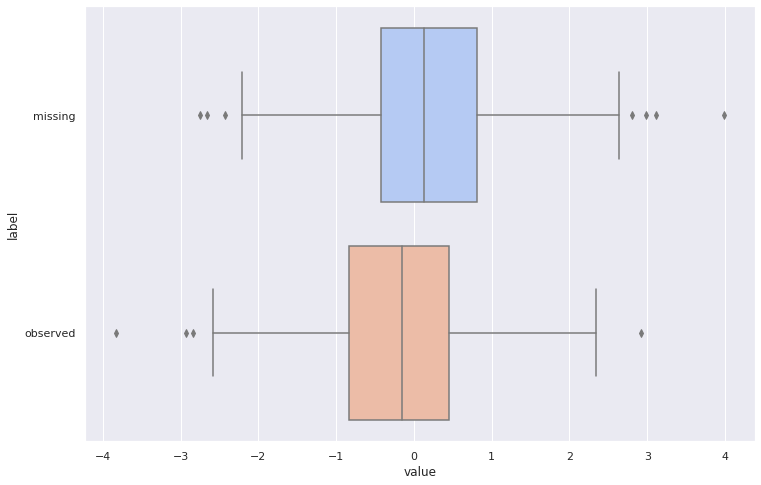

In [88]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='value', y='label', data=df_tidy2, palette='coolwarm')

## Imputation

How does the complete case imputation approach compare with the actual data?

In [89]:
df_dropped = df_obs.dropna(how='any')
df_dropped['label'] = 'dropped'
df_complete['label'] = 'complete'
df_full = pd.concat([df_dropped, df_complete])

df_full = df_full.reset_index().iloc[:, 1:]

/tmp/ipykernel_134878/2650860579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped['label'] = 'dropped'


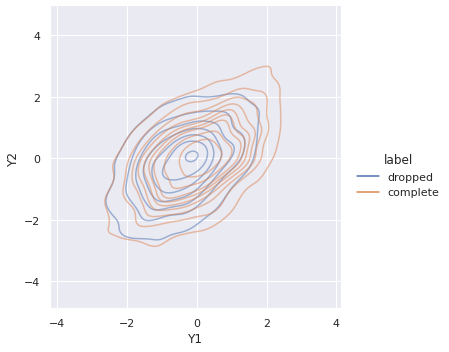

In [90]:
ax = sns.displot(data=df_full, x='Y1', y='Y2', hue='label', alpha=0.5, kind='kde')

In [91]:
# distributions of Y1 when Y2 is missing vs not
Y1_obs = df_obs[df_obs['Y2'].isnull() == False]['Y1'].values
Y1_mis = df_obs[df_obs['Y2'].isnull() == True]['Y1'].values

df_Y1_obs = pd.DataFrame(data={'Y1': Y1_obs})
df_Y1_obs['missing'] = 0

df_Y1_mis = pd.DataFrame(data={'Y1': Y1_mis})
df_Y1_mis['missing'] = 1

df_Y1 = pd.concat([df_Y1_mis, df_Y1_obs]).reset_index().iloc[:, 1:]

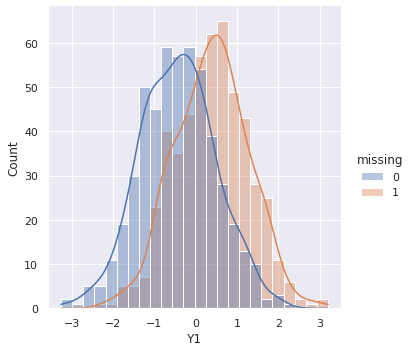

In [92]:
# Y1 tends to be larger when Y2 is missing
ax = sns.displot(data=df_Y1, x='Y1', hue='missing', alpha=0.4, kde=True)

## MNAR: Missing Not At Random

$P(R_2=0) = \frac{e^{Y_2}}{1 + e^{Y_2}}\psi_2$,

where $\psi_2=0.5$.

The probability of being missing in Y2 depends on Y2 itself, i.e., on information that is not measured.

In [93]:
vals = np.random.rand(Y2.shape[0]).reshape(-1, 1)
R_mnar = 1 - (sigmoid(Y2) >= vals).astype(int)

In [94]:
# the observed dataset
df_obs = df_complete.copy()
df_obs.loc[np.where(R_mnar == 0)[0], 'Y2'] = np.nan

# the missing dataset
df_mis = df_complete.copy()
df_mis['col1'] = 0
df_mis['col2'] = 0
df_mis.loc[np.where(R_mnar == 0)[0], 'col2'] = Y2.reshape(-1,)[R_mnar.reshape(-1,) == 0]

In [95]:
# what do the observed and the missing distributions look like for Y2?
Y2_obs = df_obs[df_obs['Y2'].isnull() == False]['Y2'].values
Y2_mis = df_mis[df_obs['Y2'].isnull()]['Y2'].values

In [96]:
data_labels = ['observed' for _ in range(0, Y2_obs.shape[0])] + ['missing' for _ in range(0, Y2_mis.shape[0])]
data_values = np.concatenate([Y2_obs, Y2_mis])

df_tidy3 = pd.DataFrame(data={'value': data_values, 'label': data_labels})
df_tidy3['label'] = df_tidy3['label'].astype('category')

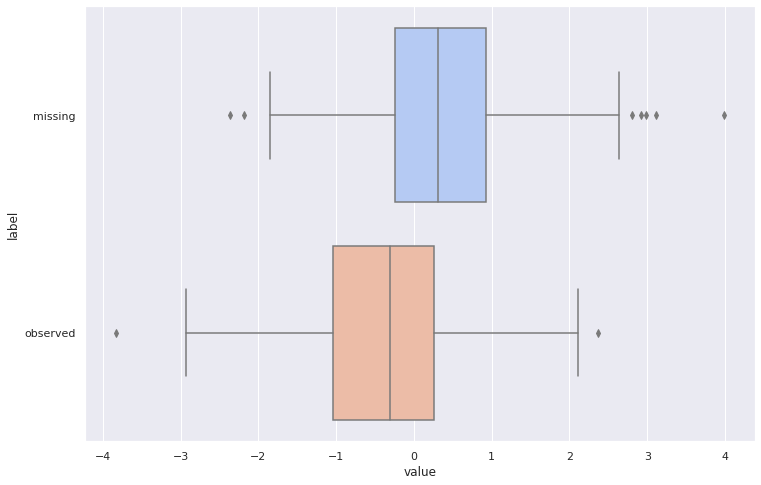

In [97]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='value', y='label', data=df_tidy3, palette='coolwarm')

In [98]:
# how does the complete case imputation approach compare with the actual data?
df_dropped = df_obs.dropna(how='any')
df_dropped['label'] = 'dropped'
df_complete['label'] = 'complete'
df_full = pd.concat([df_dropped, df_complete])

df_full = df_full.reset_index().iloc[:, 1:]

/tmp/ipykernel_134878/1491704610.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped['label'] = 'dropped'


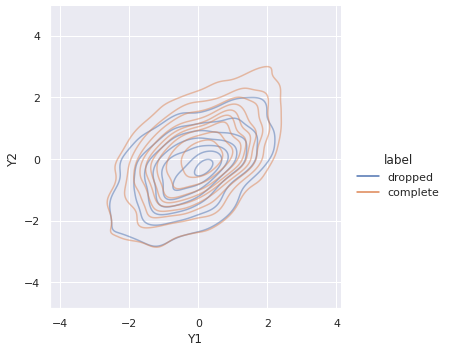

In [99]:
ax = sns.displot(data=df_full, x='Y1', y='Y2', hue='label', alpha=0.5, kind='kde')

In [100]:
# distributions of Y1 when Y2 is missing vs not
Y1_obs = df_obs[df_obs['Y2'].isnull() == False]['Y1'].values
Y1_mis = df_obs[df_obs['Y2'].isnull() == True]['Y1'].values

df_Y1_obs = pd.DataFrame(data={'Y1': Y1_obs})
df_Y1_obs['missing'] = 0

df_Y1_mis = pd.DataFrame(data={'Y1': Y1_mis})
df_Y1_mis['missing'] = 1

df_Y1 = pd.concat([df_Y1_mis, df_Y1_obs]).reset_index().iloc[:, 1:]

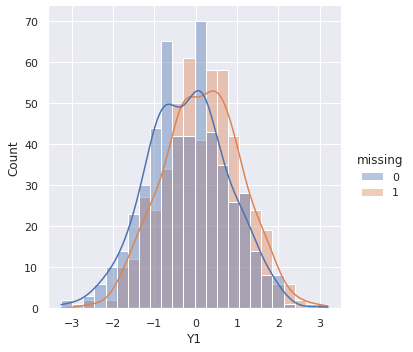

In [101]:
# Y1 tends to be larger when Y2 is missing due to the correlation between Y1 and Y2
# and the fact that the probability of Y2 being missing is higher when Y2 is larger
ax = sns.displot(data=df_Y1, x='Y1', hue='missing', alpha=0.4, kde=True)

## Summary of distributions of missing vs non missing values

In [104]:
df_tidy1['mechanism'] = 'MCAR'
df_tidy2['mechanism'] = 'MAR'
df_tidy3['mechanism'] = 'MNAR'

In [105]:
df_tidy_all = pd.concat([df_tidy1, df_tidy2, df_tidy3])

In [106]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='value', y='label', data=df_tidy_all, palette='coolwarm')

,value,label,mechanism
0,1.084175,observed,MCAR
1,-0.321132,observed,MCAR
2,-0.658685,observed,MCAR
3,-0.535405,observed,MCAR
4,0.308568,observed,MCAR
...,...,...,...
1019,1.066443,missing,MNAR
1020,1.734675,missing,MNAR
1021,1.061717,missing,MNAR
1022,1.197661,missing,MNAR


/home/alex/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1152x576 with 0 Axes>

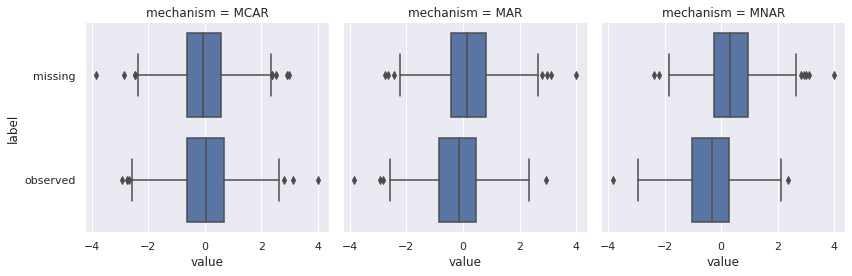

In [141]:
plt.figure(figsize=(16, 8))
g = sns.FacetGrid(df_tidy_all, col="mechanism", height=4)
g.map(sns.boxplot, 'value', 'label')
plt.show()